# Preparing the data of behavior.tsv and news.tsv #

In [56]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

base_path = r"C:\Users\stefa\DTU\CDTS"

news_path = Path(base_path) / 'news.tsv'
behaviors_path = Path(base_path) / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url',
                                               'title_entities', 'abstract_entities'])

behaviors = pd.read_csv(behaviors_path, sep='\t',
                           names=['impression_id', 'user_id', 'time', 'history', 'impressions'])



news = news.dropna()
behaviors = behaviors.dropna()

# Hierarchical Clustering for Category and Subcategory

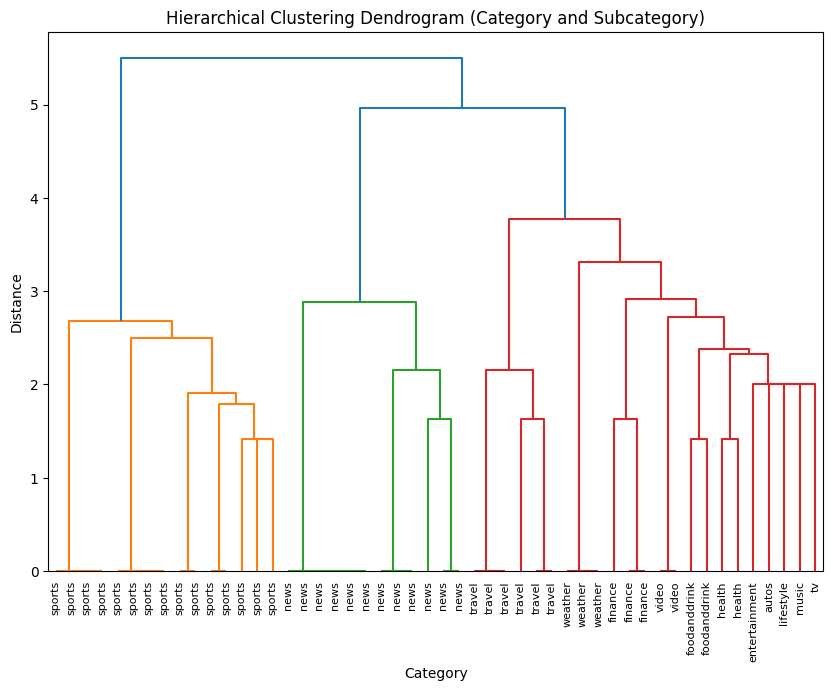

In [57]:
news_sample = news.sample(n=50, random_state=42)
behaviors_sample = behaviors.sample(n=50, random_state=42)

encoder = OneHotEncoder()
category_features = encoder.fit_transform(news_sample[['category', 'subcategory']]).toarray()

linkage_matrix = linkage(category_features, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=news_sample['category'].values)
plt.title('Hierarchical Clustering Dendrogram (Category and Subcategory)')
plt.xlabel('Category')
plt.ylabel('Distance')
plt.show()


# Hierarchical Clustering for Subcategory in Category "News"

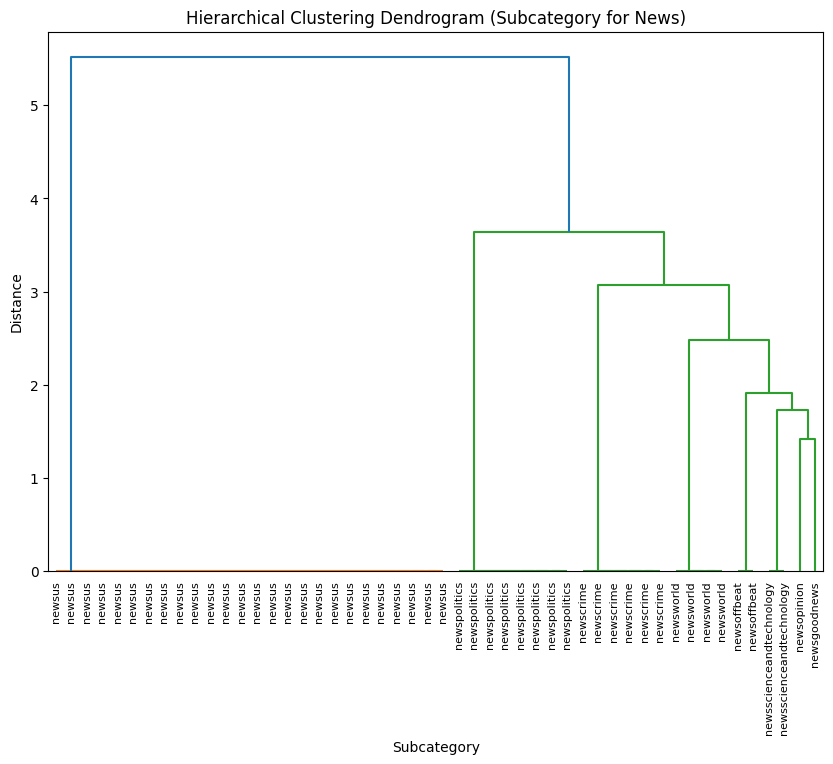

In [58]:
news_subcategories = news[news['category'] == 'news']

news_sample = news_subcategories.sample(n=50, random_state=42)

encoder = OneHotEncoder()
category_features = encoder.fit_transform(news_sample[['subcategory']]).toarray()

linkage_matrix = linkage(category_features, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=news_sample['subcategory'].values)
plt.title('Hierarchical Clustering Dendrogram (Subcategory for News)')
plt.xlabel('Subcategory')
plt.ylabel('Distance')
plt.show()

# K-Means Clustering: Use Elbow-Method

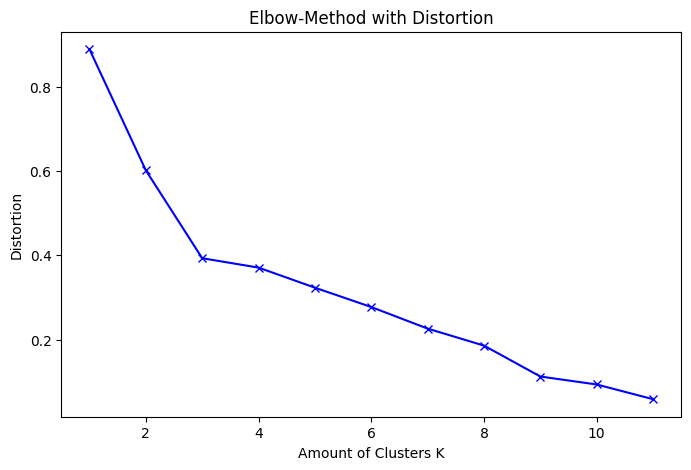

In [59]:
categories = news[['category']]

encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(categories)

def plotElbowChart(data, K=range(1, 12)):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(data)
        
        distortion = sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        distortions.append(distortion)
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = distortion
        mapping2[k] = kmeanModel.inertia_

    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Amount of Clusters K')
    plt.ylabel('Distortion')
    plt.title('Elbow-Method with Distortion')
    plt.show()

plotElbowChart(category_encoded)

# K-Meas Clustering for Category

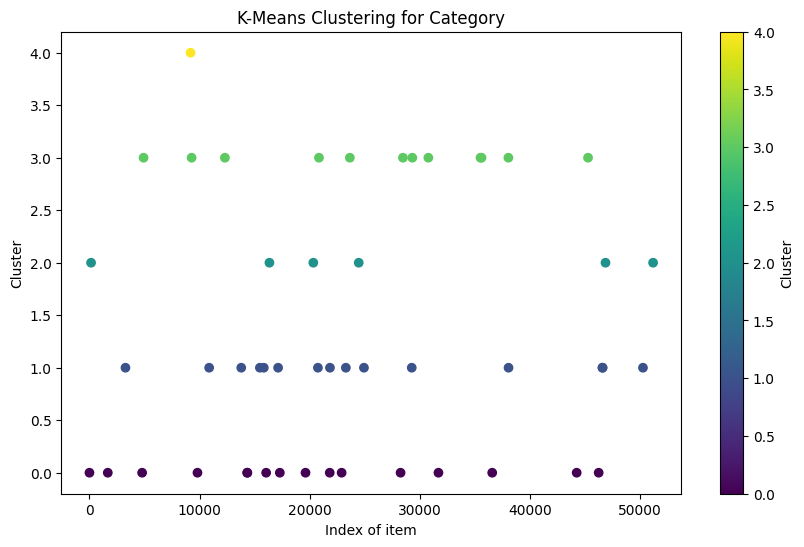

In [60]:
news = news.sample(n=50, random_state=42)
behaviors = behaviors.sample(n=50, random_state=42)

encoder = OneHotEncoder()
category_features = encoder.fit_transform(news[['category', 'subcategory']]).toarray()

linkage_matrix = linkage(category_features, method='ward')

kmeans = KMeans(n_clusters=5, random_state=42)
news['Cluster'] = kmeans.fit_predict(category_features)

plt.figure(figsize=(10, 6))
plt.scatter(news.index, news['Cluster'], c=news['Cluster'], cmap='viridis', label='Cluster')
plt.title('K-Means Clustering for Category')
plt.xlabel('Index of item')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster')
plt.show()

# Recommend titles based on user behavior

In [61]:
def create_user_profile(user_history, news_data):
    history_ids = user_history.split()
    categories = news_data[news_data['news_id'].isin(history_ids)]['category']
    profile = categories.value_counts(normalize=True).to_dict()
    return profile

user_profiles = {}
for idx, row in behaviors.iterrows():
    user_profiles[row['user_id']] = create_user_profile(row['history'], news)

def recommend_articles(user_id, user_profiles, news_data, cluster_model, top_n=5):
    user_profile = user_profiles[user_id]
    preferred_clusters = [cluster for cluster, weight in user_profile.items() if weight > 0.2]  
    history_ids = behaviors[behaviors['user_id'] == user_id]['history'].values[0].split()
    recommendations = news_data[(news_data['Cluster'].isin(preferred_clusters)) & (~news_data['news_id'].isin(history_ids))]
    return recommendations[['news_id', 'title']].head(top_n)

user_id =  behaviors['user_id'].sample(n=1).values[0]

recommended_articles = recommend_articles(user_id, user_profiles, news, kmeans)
print(f"Recommendation for user {user_id}:")
print(recommended_articles)

Recommendation for user U77463:
Empty DataFrame
Columns: [news_id, title]
Index: []
